In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import os.path as op
import glob
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
# Suppress convergence warnings from statsmodels
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
%matplotlib inline

# Set visualization context
sns.set_context('talk')


In [2]:
def load_data():
    """Load original data from pilot5.csv"""
    df_orig = pd.read_csv('pilot5.csv')
    participant_set = set(df_orig['participant'])
    return df_orig, participant_set

def process_data_files(participant_set):
    """Process and filter all data files from the directory"""
    home_dir = op.abspath('./')
    data_files = glob.glob(op.join(home_dir, 'data', '*.csv'))
    
    df_list = []
    error_count = 0
    
    for sub in data_files:
        try:
            sub_df = pd.read_csv(sub)
            
            # Filter for participants in participant_set
            if any(sub_df['participant'].isin(participant_set)):
                # Filter for non-empty 'image_recall_response.keys' and reset the index
                data = sub_df.loc[sub_df['image_recall_response.keys'].notna()].reset_index(drop=True)
                df_list.append(data.copy())
        except Exception as e:
            error_count += 1
            # Collect error stats instead of printing every error
            
    print(f"Processed {len(data_files)} files with {error_count} errors")
    
    # Concatenate all filtered data into a single DataFrame
    df = pd.concat(df_list, ignore_index=True) if df_list else pd.DataFrame()
    
    # Get the count of unique participants
    unique_participants_count = len(set(df['participant']))
    print(f"Found {unique_participants_count} unique participants")
    
    return df

In [3]:
def remove_unit_variance(df, col, unit, group=None, suffix="_within"):
    """Remove variance between sampling units.
    
    This is useful for plotting repeated-measures data using within-unit
    error bars.
    """
    new_col = col + suffix

    def demean(x):
        return x - x.mean()

    if group is None:
        new = df.groupby(unit)[col].transform(demean)
        new += df[col].mean()
        df.loc[:, new_col] = new
    else:
        df.loc[:, new_col] = np.nan
        for level, df_level in df.groupby(group):
            new = df_level.groupby(unit)[col].transform(demean)
            new += df_level[col].mean()
            df.loc[new.index, new_col] = new

    return df

In [5]:
def fill_non_nan_columns(row, df_orig):
    """Fill non-NaN columns from the original DataFrame"""
    # Locate matching rows in df_orig based on participant and image conditions
    matching_rows = df_orig[
        (df_orig['participant'] == row['participant']) &
        ((df_orig['img1'] == row['ImagePath']) | 
         (df_orig['img2'] == row['ImagePath']) | 
         (df_orig['ping_img'] == row['ImagePath']))
    ]
    
    # Copy non-NaN columns from the first matching row in df_orig if there's a match
    if not matching_rows.empty:
        match = matching_rows.iloc[0]
        for col in match.index:
            # Skip columns that identify rows (not to be copied over) and only copy non-NaN values
            if col not in ['participant'] and pd.notna(match[col]):
                row[col] = match[col]
    return row

def round_to_significant_figures(x, sig_figs=2):
    """Round value to specified number of significant figures"""
    if x == 0:
        return 0
    else:
        return round(x, sig_figs - int(np.floor(np.log10(abs(x)))) - 1)
def process_interval(interval):
    """Process interval by rounding bounds to significant figures"""
    # Round both bounds
    lower_rounded = round_to_significant_figures(interval.left)
    upper_rounded = round_to_significant_figures(interval.right)
    # Return a new interval with the rounded bounds
    return pd.Interval(lower_rounded, upper_rounded)

In [6]:

def process_combined_data(df, df_orig):
    """Process and enrich the combined DataFrame"""
    # Combine dataframes
    combined_df = pd.concat([df, df_orig], ignore_index=True)
    
    # Calculate response counts
    response_counts = combined_df.groupby('participant')['image_recall_response.keys'].count().reset_index()
    response_counts = response_counts.rename(columns={'image_recall_response.keys': 'image_recall_response_count'})
    
    # Get minimum response count and threshold statistics
    min_response_count = response_counts['image_recall_response_count'].min()
    threshold = 250 * (2 / 3)
    below_threshold_count = (response_counts['image_recall_response_count'] < threshold).sum()
    
    print(f"Minimum response count: {min_response_count}")
    print(f"Participants below threshold ({threshold}): {below_threshold_count}")
    
    # Add calculated columns
    combined_df['acc_recall'] = np.where(combined_df['ImagePath'].str.contains("foil", case=False, na=False), 0, 1)
    
    combined_df['mem_answ'] = np.where(combined_df['image_recall_response.keys'].isin([1, 2]), 0,
                                     np.where(combined_df['image_recall_response.keys'].isin([3, 4]), 1, np.nan))
    
    # Calculate recall answer
    combined_df['recall_answ'] = np.where(
        combined_df['mem_answ'].isna() | combined_df['acc_recall'].isna(), np.nan,
        np.where(
            (combined_df['mem_answ'] == 0) & (combined_df['acc_recall'] == 0) | 
            (combined_df['mem_answ'] == 1) & (combined_df['acc_recall'] == 1), 1, 0)
    )
    
    # Filter for reasonable response times
    combined_df = combined_df[combined_df['image_recall_response.rt'] <= 4]
    
    # Add answer labels
    answer_mapping = {1: 'Definitely not seen', 2: 'Probably not seen',
                      3: 'Probably seen', 4: 'Definitely seen'}
    combined_df['Answer Labels'] = combined_df['image_recall_response.keys'].map(answer_mapping)
    
    # Set as main dataframe
    df = combined_df
    
    # Add past response correctness column
    df['Past Response Correctness'] = np.where(df['acc_recall'] == 1, 'Correct', 'Wrong')
    
    # Fill in columns from original dataframe
    df = df.apply(lambda row: fill_non_nan_columns(row, df_orig) if row['acc_recall'] == 1 else row, axis=1)
    
    # Remove unit variance
    df = remove_unit_variance(df, 'mouse.time_last', 'participant')
    df['analysis_rt'] = df['mouse.time_last_within']
    
    # Process categorical columns
    column_params = {
        'v2': {'n_cats': 5, 'labels': ['Least Similar', '', ' ', '   ', 'Most Similar']},
        'it': {'n_cats': 5, 'labels': ['Least Similar', '', ' ', '   ', 'Most Similar']}
    }
    
    # Define columns to categorize
    similarity_columns = [
        'it_sim_dis_attend', 'v2_sim_dis_attend', 'it_sim_dis_unattend', 'v2_sim_dis_unattend', 
        'it_sim_dis_diff', 'v2_sim_dis_diff', 'it_im1_im2', 'v2_im1_im2', 'it_sim_dis_test', 
        'v2_sim_dis_test', 'it_sim_dis_untest', 'v2_sim_dis_untest', 'it_sim_dis_diff_test', 
        'v2_sim_dis_diff_test', 'v2_sim_dis_diff_sq', 'it_sim_dis_diff_sq', 
        'v2_sim_dis_diff_test_sq', 'it_sim_dis_diff_test_sq'
    ]
    
    # Create categorical versions
    for label in similarity_columns:
        if 'v2' in label:
            n_cats = column_params['v2']['n_cats']
            labels = column_params['v2']['labels']
        else:
            n_cats = column_params['it']['n_cats']
            labels = column_params['it']['labels']
        
        df[label + '_cat'] = pd.qcut(df[label], q=n_cats, labels=labels, duplicates='drop')
    
    # Map category columns
    df['V2 Distractor Similarity\nto Prioritized Item'] = df['v2_sim_dis_attend_cat']
    df['IT Distractor Similarity\nto Prioritized Item'] = df['it_sim_dis_attend_cat']
    df['V2 Distractor Similarity\nto Deprioritized Item'] = df['v2_sim_dis_unattend_cat']
    df['IT Distractor Similarity\nto Deprioritized Item'] = df['it_sim_dis_unattend_cat']
    df['Prioritized - Deprioritized IT Distractor Similarity'] = df['it_sim_dis_diff_cat'] 
    df['Prioritized - Deprioritized V2 Distractor Similarity'] = df['v2_sim_dis_diff_cat'] 
    df['Prioritized - Deprioritized IT Distractor Similarity Squared'] = df['v2_sim_dis_diff_sq_cat'] 
    df['Prioritized - Deprioritized V2 Distractor Similarity Squared'] = df['it_sim_dis_diff_sq_cat'] 
    
    df['V2 Distractor Similarity\nto Tested Item'] = df['v2_sim_dis_test_cat']
    df['IT Distractor Similarity\nto Tested Item'] = df['it_sim_dis_test_cat']
    df['V2 Distractor Similarity\nto Untested Item'] = df['v2_sim_dis_untest_cat']
    df['IT Distractor Similarity\nto Untested Item'] = df['it_sim_dis_untest_cat']
    df['Tested - Untested IT Distractor Similarity'] = df['it_sim_dis_diff_test_cat'] 
    df['Tested - Untested V2 Distractor Similarity'] = df['v2_sim_dis_diff_test_cat'] 
    df['Tested - Untested IT Distractor Similarity Squared'] = df['v2_sim_dis_diff_test_sq_cat'] 
    df['Tested - Untested V2 Distractor Similarity Squared'] = df['it_sim_dis_diff_test_sq_cat'] 
    
    # Process metadata columns
    df['tested_item'] = df['Tested Item']
    df['ret_rel'] = df['Retrocue Reliability']
    
    # Create binned versions of difference measures
    diff_columns = [
        ('it_sim_dis_diff', 'IT_diff_binned'), 
        ('v2_sim_dis_diff', 'V2_diff_binned'),
        ('it_sim_dis_diff_sq', 'IT_diff_binned_sq'), 
        ('v2_sim_dis_diff_sq', 'V2_diff_binned_sq'),
        ('it_sim_dis_diff_test', 'IT_diff_binned_test'), 
        ('v2_sim_dis_diff_test', 'V2_diff_binned_test'),
        ('it_sim_dis_diff_test_sq', 'IT_diff_binned_test_sq'), 
        ('v2_sim_dis_diff_test_sq', 'V2_diff_binned_test_sq')
    ]
    
    for src_col, dest_col in diff_columns:
        df[dest_col] = pd.qcut(df[src_col], 5, duplicates='drop')
        df[dest_col] = df[dest_col].apply(process_interval)
    
    # Map the range columns
    df['Prioritized - Deprioritized V2 Distractor Similarity Ranges'] = df['V2_diff_binned']
    df['Prioritized - Deprioritized IT Distractor Similarity Ranges'] = df['IT_diff_binned']
    df['Prioritized - Deprioritized V2 Distractor Similarity Squared Ranges'] = df['V2_diff_binned_sq']
    df['Prioritized - Deprioritized IT Distractor Similarity Squared Ranges'] = df['IT_diff_binned_sq']
    
    df['Tested - Untested V2 Distractor Similarity Ranges'] = df['V2_diff_binned_test']
    df['Tested - Untested IT Distractor Similarity Ranges'] = df['IT_diff_binned_test']
    df['Tested - Untested V2 Distractor Similarity Squared Ranges'] = df['V2_diff_binned_test_sq']
    df['Tested - Untested IT Distractor Similarity Squared Ranges'] = df['IT_diff_binned_test_sq']
    
    # Assign z-score versions of similarity measures
    df['V2 Distractor Similarity to Tested Item'] = df['v2_sim_dis_test_z']
    df['IT Distractor Similarity to Tested Item'] = df['it_sim_dis_test_z']
    df['Tested - Untested V2 Distractor Similarity'] = df['v2_sim_dis_diff_test_z']
    df['Tested - Untested IT Distractor Similarity'] = df['it_sim_dis_diff_test_z']
    
    # df['V2 Distractor Similarity to LTM Item'] = df['v2_sim_dis_test_z']
    # df['IT Distractor Similarity to LTM Item'] = df['it_sim_dis_test_z']
    # df['LTM - NonLTM V2 Distractor Similarity'] = df['v2_sim_dis_diff_test_z']
    # df['LTM - NonLTM IT Distractor Similarity'] = df['it_sim_dis_diff_test_z']
    
    # Create category column
    df['category'] = df.apply(
        lambda row: 'distractor' if row['ImagePath'] == row['ping_img']
        else ('foil' if 'foil' in str(row['ImagePath']).lower()
              else ('tested' if ((row['ImagePath'] == row['img1'] and row['test_item'] == 'img1') or 
                                 (row['ImagePath'] == row['img2'] and row['test_item'] == 'img2'))
                    else 'not tested')),
        axis=1
    )
    
    # Memory stimulus type
    df['mem_stim_type'] = df.apply(
        lambda row: 'distractor' if row['ImagePath'] == row['ping_img']
        else (('tested' if ((row['ImagePath'] == row['img1'] and row['test_item'] == 'img1') or 
                             (row['ImagePath'] == row['img2'] and row['test_item'] == 'img2'))
                else 'not tested')),
        axis=1
    )
    df['Tested'] = df['mem_stim_type']
    
    # Attend column
    df['Attend'] = df.apply(
        lambda row: 'distractor' if row['ImagePath'] == row['ping_img']
        else 'foil' if (row['category']== 'foil')
        else 'attended' if ((row['ImagePath'] == row['img1'] and row['attend'] == 'img1') or 
                             (row['ImagePath'] == row['img2'] and row['attend'] == 'img2'))
        else 'not attended',
        axis=1
    )
    
    # Reliability column
    df['Reliability'] = df.apply(
        lambda row: 'foil' if (row['category']== 'foil')
        else 'high' if row['reliability'] > 0.7
        else 'low' if row['reliability'] < 0.7
        else None,
        axis=1
    )
    
    # Create standardized binary columns
    scaler = StandardScaler()
    
    df['reliability_binary'] = np.where(df['Reliability'] == 'low', -1, 1)
    df['tested_binary'] = np.where(df['Tested'] == 'tested', -1, 1)
    df['priority_binary'] = np.where(df['Tested Item'] == 'prioritized', -1, 1)
    df['attend_binary'] = np.where(df['Attend'] == 'attended', -1, 1)
    
    # Create z-score versions
    binary_cols = ['reliability_binary', 'tested_binary', 'priority_binary', 'attend_binary']
    for col in binary_cols:
        df[f'{col}_z'] = scaler.fit_transform(df[[col]])
    
    # # Create indicator variables
    # df['it_pos_neg'] = np.where(df['it_sim_dis_diff_test_z'] <= 0, 0, 1)
    # df['v2_pos_neg'] = np.where(df['v2_sim_dis_diff_test_z'] <= 0, 0, 1)
    # df['it_pos_neg_abs'] = np.where(df['it_sim_dis_test_z'] <= 0, 0, 1)
    # df['v2_pos_neg_abs'] = np.where(df['v2_sim_dis_test_z'] <= 0, 0, 1)
    
    # Apply unit variance removal again
    df = remove_unit_variance(df, 'recall_answ', 'participant')
    
    return df

In [7]:
def create_derived_dataframes(df):
    """Create filtered dataframes and calculate LTM differences"""
    # Create distractor dataframe
    df_distractor = df[df['category'] == 'distractor']
    
    # Create filtered dataframe for tested/not tested items
    df_filtered = df[(df['category'] == 'tested') | (df['category'] == 'not tested')]
    
    # Calculate IT and V2 LTM values
    df_filtered['it_ltm'] = df_filtered.apply(
        lambda row: 'distractor' if row['ImagePath'] == row['ping_img'] else (
            row['IT_root_im1'] if (row['ImagePath'] == row['img1']) else (
                row['IT_root_im2'] if (row['ImagePath'] == row['img2']) else 
                'not tested'
            )
        ),
        axis=1
    )
    
    df_filtered['v2_ltm'] = df_filtered.apply(
        lambda row: 'distractor' if row['ImagePath'] == row['ping_img'] else (
            row['V2_root_im1'] if (row['ImagePath'] == row['img1']) else (
                row['V2_root_im2'] if (row['ImagePath'] == row['img2']) else 
                'not tested'
            )
        ),
        axis=1
    )
    
    # Calculate IT and V2 LTM differences
    df_filtered['it_ltm_diff'] = df_filtered.apply(
        lambda row: 'distractor' if row['ImagePath'] == row['ping_img'] else (
            (row['IT_root_im1'] - row['IT_root_im2']) if (row['ImagePath'] == row['img1']) else (
                (row['IT_root_im2'] - row['IT_root_im1']) if (row['ImagePath'] == row['img2']) else 
                'not tested'
            )
        ),
        axis=1
    )
    
    df_filtered['v2_ltm_diff'] = df_filtered.apply(
        lambda row: 'distractor' if row['ImagePath'] == row['ping_img'] else (
            (row['V2_root_im1'] - row['V2_root_im2']) if (row['ImagePath'] == row['img1']) else (
                (row['V2_root_im2'] - row['V2_root_im1']) if (row['ImagePath'] == row['img2']) else 
                'not tested'
            )
        ),
        axis=1
    )
    
    return df_distractor, df_filtered


In [19]:
def generate_plots(df, df_filtered):
    """Generate all the analysis plots from the original notebook"""
    # Define consistent color palette
    palette = sns.color_palette("husl", n_colors=2)[::-1]
    
    # Plot 1: Recall answer distribution
    plt.figure(figsize=(6, 4))
    recall_counts = df['recall_answ'].value_counts()
    recall_counts.plot(kind='bar', color=['lightblue', 'salmon'])
    plt.xlabel('Correct vs incorrect answer distribution')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.savefig('recall_distribution.png', dpi=300)
    plt.show()
    label_order = [
        'Definitely not seen', 
        'Probably not seen', 
        'Probably seen', 
        'Definitely seen'
    ]
    
    answer_counts = df['Answer Labels'].value_counts()
    answer_counts = answer_counts.reindex(label_order)
    
    plt.figure(figsize=(8, 5))
    answer_counts.plot(kind='bar', color='lightcoral')
    plt.title('Distribution of Answer Labels')
    plt.xlabel('Answer Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('answer_distribution.png', dpi=300)
    plt.show()
    
    # Plot 3 & 4: Distribution of correct and incorrect answers
    correctLTM_df = df[df['recall_answ'] == 1]
    wrongLTM_df = df[df['recall_answ'] == 0]
    
    answer_counts_corr = correctLTM_df['Answer Labels'].value_counts()
    answer_counts_corr = answer_counts_corr.reindex(label_order)
    
    plt.figure(figsize=(8, 5))
    answer_counts_corr.plot(kind='bar', color='lightcoral')
    plt.title('Distribution of Answer Labels when response is correct')
    plt.xlabel('Answer Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('correct_responses.png', dpi=300)
    plt.show()
    
    answer_counts_incorr = wrongLTM_df['Answer Labels'].value_counts()
    answer_counts_incorr = answer_counts_incorr.reindex(label_order)
    
    plt.figure(figsize=(8, 5))
    answer_counts_incorr.plot(kind='bar', color='lightcoral')
    plt.title('Distribution of Answer Labels when response is incorrect')
    plt.xlabel('Answer Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('incorrect_responses.png', dpi=300)
    plt.show()
    
    # Plot 5: Response times for correct vs incorrect answers
    response_time_column = 'image_recall_response.rt'
    correct_response_times = df[df['recall_answ'] == 1][response_time_column].dropna()
    incorrect_response_times = df[df['recall_answ'] == 0][response_time_column].dropna()
    
    plt.figure(figsize=(12, 6))
    sns.histplot(correct_response_times, color='green', kde=True, label='Correct Responses', binwidth=0.5)
    sns.histplot(incorrect_response_times, color='red', kde=True, label='Incorrect Responses', binwidth=0.5)
    
    plt.title('Response Times Distribution', fontsize=14)
    plt.xlabel('Response Time (seconds)', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.legend()
    plt.tight_layout()
    plt.savefig('response_times.png', dpi=300)
    plt.show()
    
    # Plot 6: Confidence level heatmap
    confidence_mapping = {1: 'Definitely not seen', 2: 'Probably not seen', 
                                  3: 'Probably seen', 4: 'Definitely seen'}
    df['confidence_level'] = df['image_recall_response.keys'].map(confidence_mapping)

    
    df['correct_recall'] = ((df['acc_recall'] == 1) & 
                              (df['Answer Labels'].isin(['Probably seen', 'Definitely seen']))) | \
                             ((df['acc_recall'] == 0) & 
                              (df['Answer Labels'].isin(['Definitely not seen', 'Probably not seen'])))
    confidence_order = ['Definitely not seen', 'Probably not seen', 'Probably seen', 'Definitely seen']
    confidence_correctness = pd.crosstab(df['confidence_level'], df['correct_recall'], normalize='index').reindex(index=confidence_order)
    
    plt.figure(figsize=(10, 6))
    sns.heatmap(confidence_correctness, annot=True, cmap='Blues')
    plt.title('Correctness Proportion by Confidence Level')
    plt.xlabel('Is Recall Correct')
    plt.ylabel('Confidence Level')
    plt.savefig('confidence_correctness.png', dpi=300)
    plt.show()
    
    # # Plot 7: Confidence level by correctness
    # correctness_order = [False, True]
    # confidence_correctness_reversed = pd.crosstab(
    #     df['correct_recall'],
    #     df['confidence_level'],
    #     normalize='index'
    # ).reindex(index=correctness_order, columns=confidence_order)
    
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(confidence_correctness_reversed, annot=True, cmap='Blues', cbar_kws={'label': 'Proportion'})
    # plt.title('Confidence Level Proportion by Correctness')
    # plt.xlabel('Confidence Level')
    # plt.ylabel('Is Recall Correct')
    # plt.xticks(rotation=45)
    # plt.savefig('correctness_confidence.png', dpi=300)
    # plt.show()
    
    # # Plot 8: Mean correct responses by participant
    # mean_resp_correct = df.groupby('participant')['recall_answ'].mean().reset_index()
    
    # plt.figure(figsize=(10, 6))
    # sns.swarmplot(y='recall_answ', data=mean_resp_correct)
    # plt.title('Mean Correct Responses by Participant - for images definitely seen')
    # plt.xlabel('Participant')
    # plt.ylabel('Mean Correct Response')
    # plt.savefig('participant_means.png', dpi=300)
    # plt.show()
    
    return "All plots generated successfully"

Starting LTM analysis...
Loaded original data with 133 participants
Processed 1122 files with 237 errors
Found 133 unique participants
Minimum response count: 124
Participants below threshold (166.66666666666666): 1


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38760/2354285888.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['acc_recall'] = np.where(combined_df['ImagePath'].str.contains("foil", case=False, na=False), 0, 1)
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38760/2354285888.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  combined_df['mem_answ'] = np.where(combined_df['image_recall_response.keys'].isin([1, 2]), 0,
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38760/23542

Combined data processed


/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38760/1974366162.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filtered['it_ltm'] = df_filtered.apply(
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38760/1974366162.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['it_ltm'] = df_filtered.apply(
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38760/1974366162.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

Created filtered dataframe with 9572 rows


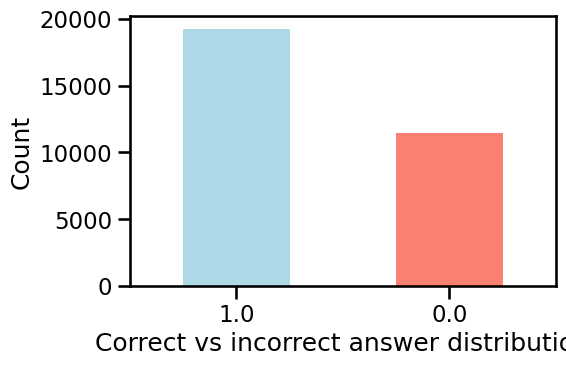

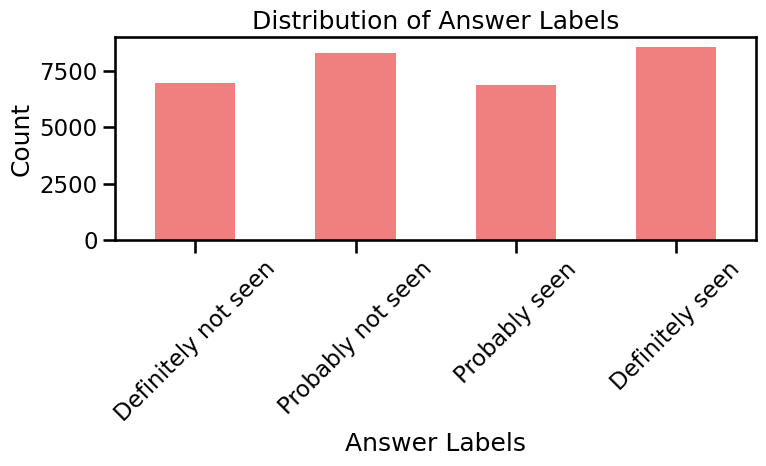

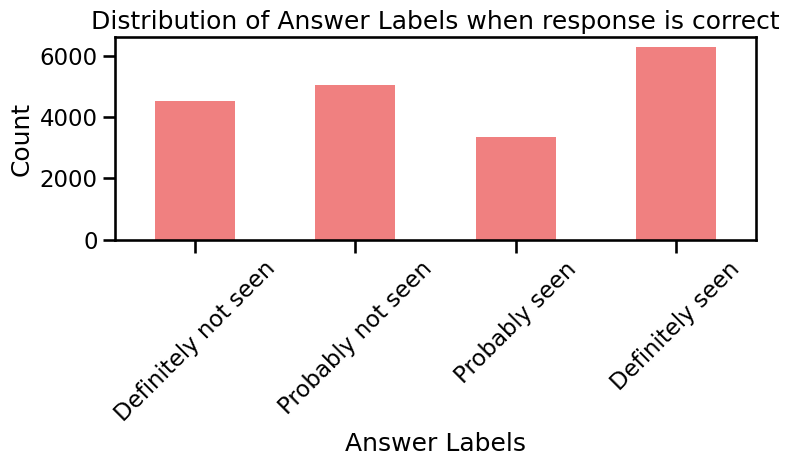

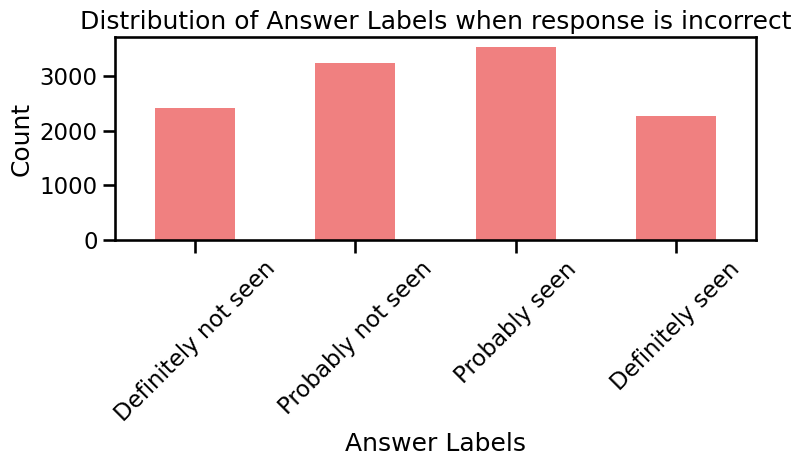

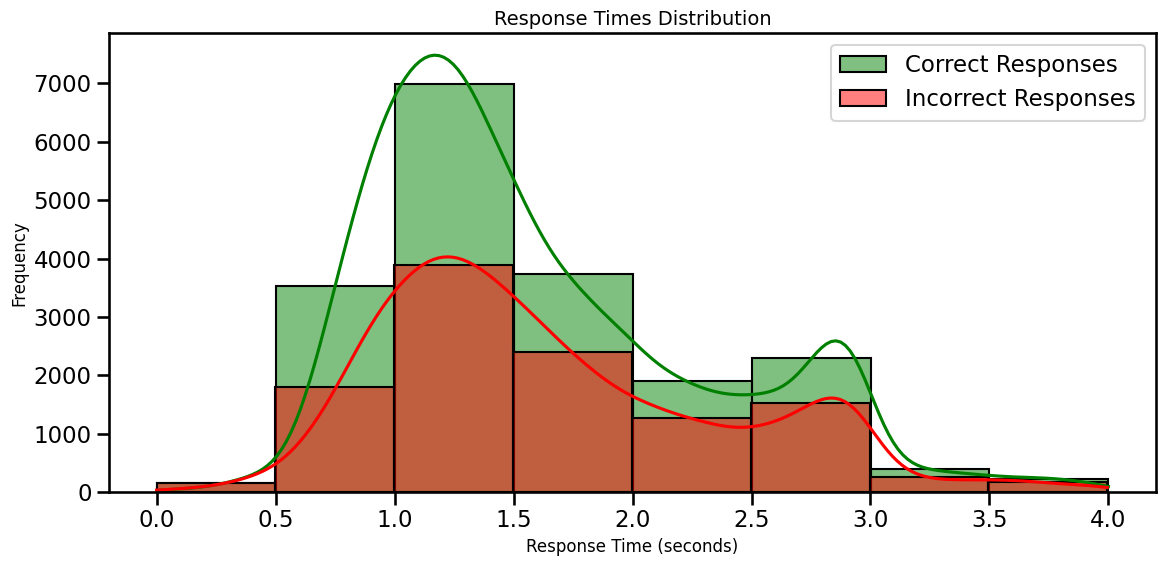

/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38760/388144266.py:86: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['confidence_level'] = df['image_recall_response.keys'].map(confidence_mapping)
/var/folders/h_/pm5z54tn7rj170br8494ljz80000gn/T/ipykernel_38760/388144266.py:89: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['correct_recall'] = ((df['acc_recall'] == 1) &


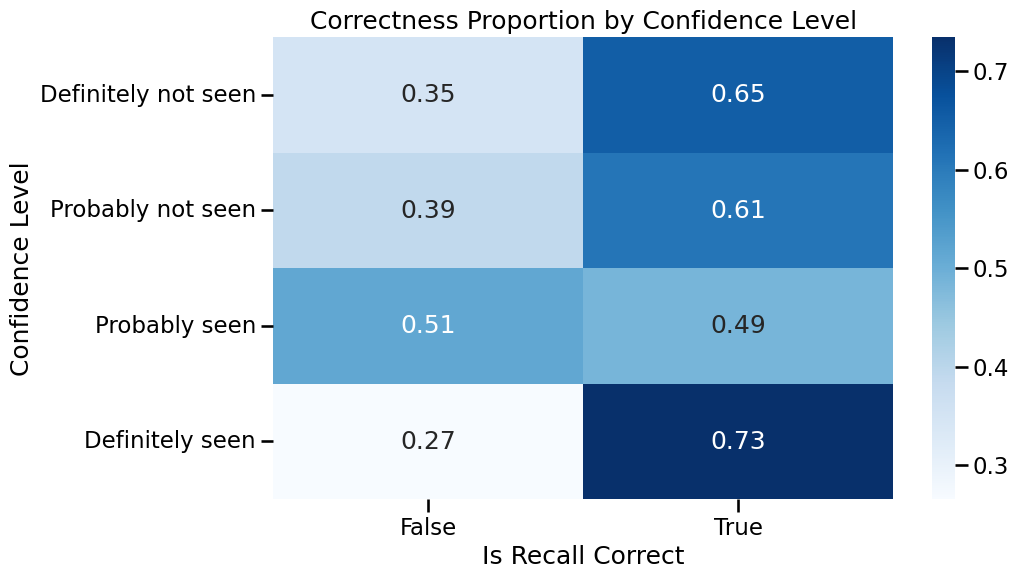

Analysis complete!


In [20]:
def main():
    """Main function to execute the analysis workflow"""
    print("Starting LTM analysis...")
    
    # Load original data
    df_orig, participant_set = load_data()
    print(f"Loaded original data with {len(participant_set)} participants")
    
    # Process all data files
    df = process_data_files(participant_set)
    
    # Process combined data
    df = process_combined_data(df, df_orig)
    print("Combined data processed")
    
    # Create derived dataframes
    df_distractor, df_filtered = create_derived_dataframes(df)
    print(f"Created filtered dataframe with {len(df_filtered)} rows")
    
    # Generate plots
    generate_plots(df, df_filtered)
    
    print("Analysis complete!")
    return df, df_filtered, df_distractor

if __name__ == "__main__":
    df, df_filtered, df_distractor = main()

In [21]:
df_g = df[df['V2_root_im1'] > 0]

df_g['V2_root_im1']

0        0.063844
2        0.072914
16       0.202404
19       0.151857
20       0.117485
           ...   
31876    0.219188
31881    0.062982
31885    0.030584
31886    0.126599
31887    0.053193
Name: V2_root_im1, Length: 15306, dtype: float64